In [38]:
import warnings
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import geopandas
import pyarrow

from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
from scipy.linalg import LinAlgWarning
from scipy.stats import pearsonr

## Parameters

In [39]:
# satellite = "landsat-8-c2-l2"
satellite = "sentinel-2"
country_code = "ZMB"
points = "15"
num_features = "5000"
feature_file_name = (f'{satellite}_{country_code}_{points}'
                     f'k-points_{num_features}-features')

## Zambia 

In [40]:
zambia_shp = geopandas.read_file(f'data/boundaries/gadm36_{country_code}_2.shp')
zambia_shp = zambia_shp.rename(columns = {'NAME_2': 'district'})[['district', 'geometry']]
zambia_shp.district = zambia_shp.district.replace("MPongwe", 'Mpongwe', regex=True)
zambia_districts = zambia_shp.district.sort_values().unique().tolist()
zambia_shp = zambia_shp.set_index('district')
zambia_shp.shape
# zambia_shp.plot(column = 'district',linewidth = 1, edgecolor = 'black' )
# zambia_shp

(72, 1)

## Crops

In [41]:
crop_df = pd.read_csv('data/crops/cfs_maize_districts_zambia_2009_2018.csv')
crop_df.district = crop_df.district.replace(
    {"Itezhi-tezhi": 'Itezhi-Tezhi',
     "Kapiri-Mposhi": 'Kapiri Mposhi',
     "Shang'ombo": 'Shangombo',
     "Chienge": 'Chiengi'
    }, regex=True)
crop_districts = crop_df.district.sort_values().unique().tolist()
crop_df = crop_df[['district', 'year', 'yield_mt']]
crop_df = crop_df.set_index('district')
# crop_df

In [42]:
list(set(crop_districts) - set(zambia_districts))

['Mafinga', 'Ikelenge']

In [43]:
list(set(zambia_districts) - set(crop_districts))

[]

In [44]:
zambia_crop = geopandas.GeoDataFrame(crop_df.join(zambia_shp), crs = zambia_shp.crs)

## Features

In [45]:
features = geopandas.GeoDataFrame()
for yr in range(2016, 2019):
    print("Opening:", yr)
    features_x = pd.read_feather(f'data/features/{feature_file_name}_{yr}.feather')
    features_x = geopandas.GeoDataFrame(
        features_x, 
        geometry = geopandas.points_from_xy(x = features_x.lon, y = features_x.lat)
        , crs='EPSG:4326'
    ).drop(['lon', 'lat'], axis = 1)
    
    print("Joining:", yr)
    zambia_x = zambia_crop[zambia_crop.year == yr]
    adm_features = features_x.sjoin(zambia_x, how = 'left', predicate = 'within')
    
    print("Appending:", yr)
    # features = features.append(adm_features)
    features = geopandas.GeoDataFrame(
        pd.concat([features, adm_features], ignore_index=True),
        crs = 'EPSG:4326'
    ).reset_index(drop = True)
    print("features.shape:", features.shape)
    print("")

Opening: 2016
Joining: 2016
Appending: 2016
features.shape: (60232, 5006)

Opening: 2017
Joining: 2017
Appending: 2017
features.shape: (120464, 5006)

Opening: 2018
Joining: 2018
Appending: 2018
features.shape: (180696, 5006)



In [46]:
features.replace([np.inf, -np.inf], np.nan, inplace=True)

In [47]:
features = features.dropna(subset=['index_right']
                          ).drop(['year_right'], axis = 1
                                ).rename(columns = {"index_right": "district", "year_left": "year"})

In [48]:
# na = features[features.isna().any(axis = 1)]
# na.plot(figsize = (15,15), markersize = 1)
# plt.savefig(f'images/nans.jpg', dpi=300)

In [49]:
features = features.dropna()

In [50]:
features_summary = features.groupby(['district',"year"], as_index = False).mean()
# features_summary

## Gradient Boosting Regression

In [51]:
from sklearn.ensemble import GradientBoostingRegressor
gb_model = GradientBoostingRegressor(n_estimators=100)

In [52]:
x_all = features_summary.drop([
    'district', 
    'year', 
    'yield_mt'], axis = 1)

# y_all = features_summary.yield_mt

y_all = np.log10(features_summary.yield_mt.to_numpy() + 1)
x_train, x_test, y_train, y_test = train_test_split(
    x_all, y_all, test_size=0.2, random_state=0
)

In [53]:
%%time
gb_model.fit(x_train, y_train)
GradientBoostingRegressor()

CPU times: total: 12.2 s
Wall time: 12.2 s


GradientBoostingRegressor()

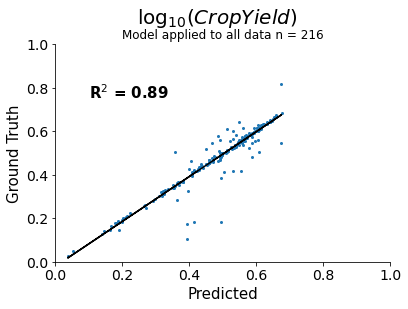

In [54]:
y_pred = np.maximum(gb_model.predict(x_all), 0)

plt.figure()
plt.scatter(y_pred, y_all, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(Crop Yield)$", fontsize=20, y=1.01)
plt.title(f"Model applied to all data n = {len(x_all)}", fontsize=12, y=1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.text(
    0.1,
    .75,
    s="R$^2$ = %0.2f" % (r2_score(y_all, y_pred)),
    fontsize=15,
    fontweight="bold",
)
m, b = np.polyfit(y_pred, y_all, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

plt.show()
plt.close()

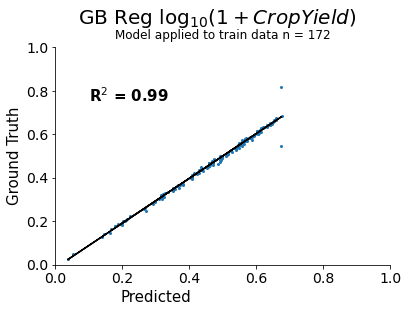

In [55]:
y_pred = np.maximum(gb_model.predict(x_train), 0)

plt.figure()
# ax = fig.figure.add_subplot()
plt.scatter(y_pred, y_train, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15, x = .3)
plt.ylabel("Ground Truth", fontsize=15)
# plt.title("Gradient boosting regression\nlog(1 + people/km$^2$)", fontsize=15)
plt.suptitle(r"GB Reg $\log_{10}(1+Crop Yield)$", fontsize=20 , y=1.02)#, x = 0.31)
plt.title(f"Model applied to train data n = {len(x_train)}", fontsize=12 , y=1.01)#, x = .32)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.text(
    0.1,
    .75,
    s="R$^2$ = %0.2f" % (r2_score(y_train, y_pred)),
    fontsize=15,
    fontweight="bold",
)
m, b = np.polyfit(y_pred, y_train, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

plt.show()
plt.close()

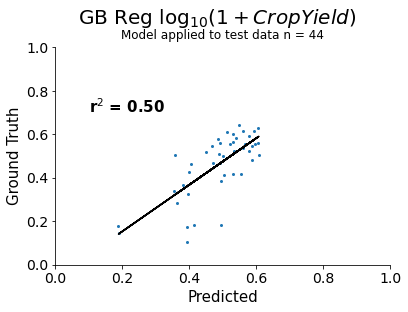

In [56]:
y_pred = np.maximum(gb_model.predict(x_test), 0)

plt.figure()
plt.scatter(y_pred, y_test, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"GB Reg $\log_{10}(1+Crop Yield)$", fontsize=20 , y=1.02)#, x = 0.31)
plt.title(f"Model applied to test data n = {len(x_test)}", fontsize=12 , y=1.01)#, x = .32)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim([0,1])
plt.ylim([0,1])

plt.text(.1,.7,s="r$^2$ = %0.2f" % (r2_score(y_test, y_pred)), fontsize=15, fontweight="bold")
m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred, m*y_pred+b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

plt.show()
plt.close()

In [ ]:
pred_features = features.copy()
x_all = pred_features.drop(['year', 'geometry', 'district', 'yield_mt'], axis = 1)
pred_features['fit'] = np.maximum(gb_model.predict(x_all), 0)

In [ ]:
plot_features = pred_features[pred_features.year == 2016]

In [ ]:
plot_features.plot(figsize = (15,15),
                   legend = True,
                   markersize = 22,
                   alpha = .9,
                   column = 'fit')